In [44]:
import tensorflow as tf
import matplotlib.pyplot as plt
import opendatasets as od

In [45]:
od.download('https://www.kaggle.com/datasets/karimabdulnabi/fruit-classification10-class')

Skipping, found downloaded files in ".\fruit-classification10-class" (use force=True to force download)


In [46]:
BATCH_SIZE = 32
IMAGE_SIZE = (128, 128)
SEED = 42
NUM_CLASSES = 10

In [47]:
def load_datasets(train_dir, test_dir):
    train_data = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        batch_size=BATCH_SIZE,
        image_size=IMAGE_SIZE,
        subset='training',
        validation_split=0.2,
        seed=SEED
    )
    val_data = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        batch_size=BATCH_SIZE,
        image_size=IMAGE_SIZE,
        subset='validation',
        validation_split=0.2,
        seed=SEED
    )
    test_data = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        batch_size=BATCH_SIZE,
        image_size=IMAGE_SIZE
    )

    class_names = train_data.class_names

    plt.figure(figsize=(10, 4))
    for images, labels in train_data.take(1):
      for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

    return train_data, val_data, test_data, class_names

In [48]:
def preprocess_datasets(train_data, val_data, test_data):
    normalization = lambda x, y: (x / 255.0, y)
    train_data = train_data.map(normalization)
    val_data = val_data.map(normalization)
    test_data = test_data.map(normalization)
    return train_data, val_data, test_data

In [49]:
# Augmentation layer
def get_augmentation_layer():
    return tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal", input_shape=(128, 128, 3)),
        tf.keras.layers.RandomRotation(0.4),
        tf.keras.layers.RandomZoom(0.4),
    ])

In [50]:
#transfer learning layer

# pre trained model one
pretrained_model = tf.keras.applications.xception.Xception(include_top=False,
                                                           input_shape=(128,128,3),
                                                           weights="imagenet",
                                                           pooling='max')

for layer in pretrained_model.layers:
        layer.trainable=False


# pre trained model MobileNet V2
IMG_SHAPE = IMAGE_SIZE + (3,)
mobileNetV2Model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet',
                                               pooling='max')
for layer in mobileNetV2Model.layers:
    layer.trainable = False

In [51]:
def build_model():
    model = tf.keras.models.Sequential([
         mobileNetV2Model,
        # tf.keras.layers.Conv2D(52, 3, activation='relu'),
        # tf.keras.layers.MaxPooling2D(),
        # tf.keras.layers.Conv2D(10, 3, activation='relu'),
        # tf.keras.layers.MaxPooling2D(),
        # tf.keras.layers.Conv2D(12, 2, activation='relu'),
        # tf.keras.layers.MaxPooling2D(),
        # tf.keras.layers.Dropout(0.2),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(75, activation='relu'),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [52]:
def train_model(model, train_data, val_data, epochs=20):
    history = model.fit(train_data, validation_data=val_data, epochs=epochs)
    return history

In [53]:
def plot_metrics(history):
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Loss', color='teal')
    plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
    plt.title('Loss Curve')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(history.history['accuracy'], label='Accuracy', color='teal')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='orange')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.show()

In [54]:
def evaluate_on_test(model, test_data):
    precision = tf.keras.metrics.Precision()
    recall = tf.keras.metrics.Recall()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    for X, y in test_data:
        yhat = model.predict(X)
        y_onehot = tf.one_hot(y, depth=NUM_CLASSES)
        precision.update_state(y_onehot, yhat)
        recall.update_state(y_onehot, yhat)
        accuracy.update_state(y_onehot, yhat)

    print("Precision:", precision.result().numpy())
    print("Recall:", recall.result().numpy())
    print("Accuracy:", accuracy.result().numpy())

Found 2301 files belonging to 10 classes.
Using 1841 files for training.
Found 2301 files belonging to 10 classes.
Using 460 files for validation.
Found 1025 files belonging to 10 classes.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 75)             │        96,075 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100)            │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 75)             │         7,575 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           760 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,369,994 (9.04 MB)

 Trainable params: 112,010 (437.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.6133 - loss: 1.1736 - val_accuracy: 0.7891 - val_loss: 0.6108
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.8827 - loss: 0.3682 - val_accuracy: 0.8500 - val_loss: 0.4178
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.9223 - loss: 0.2196 - val_accuracy: 0.8674 - val_loss: 0.4008
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - accuracy: 0.9663 - loss: 0.0991 - val_accuracy: 0.8804 - val_loss: 0.4136
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - accuracy: 0.9886 - loss: 0.0473 - val_accuracy: 0.8783 - val_loss: 0.3965
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.9967 - loss: 0.0248 - val_accuracy: 0.9022 - val_loss: 0.3428
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 1.0000 - loss: 0.0069 - val_accuracy: 0.8891 - val_loss: 0.3675
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 0

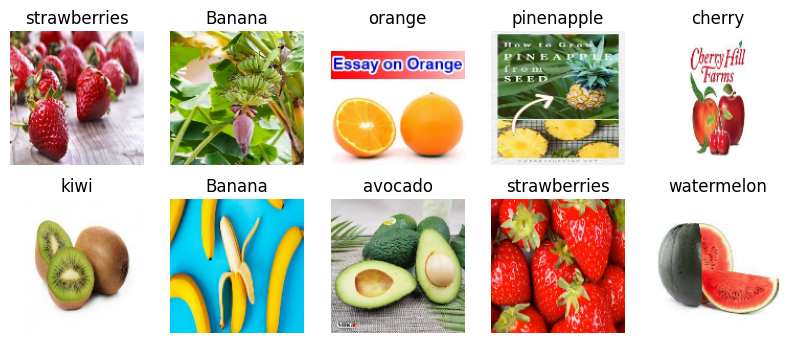

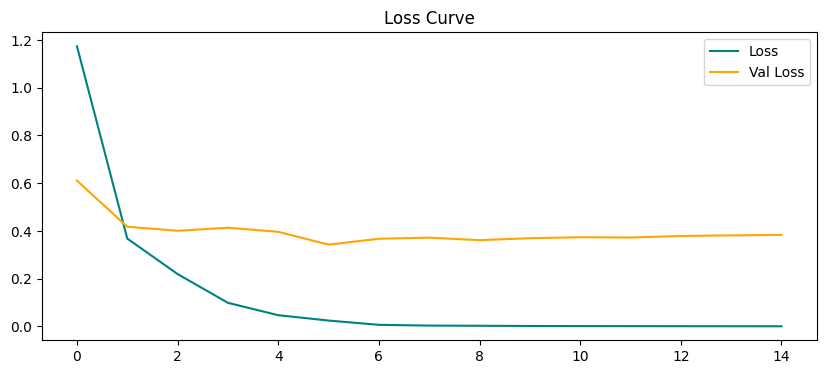

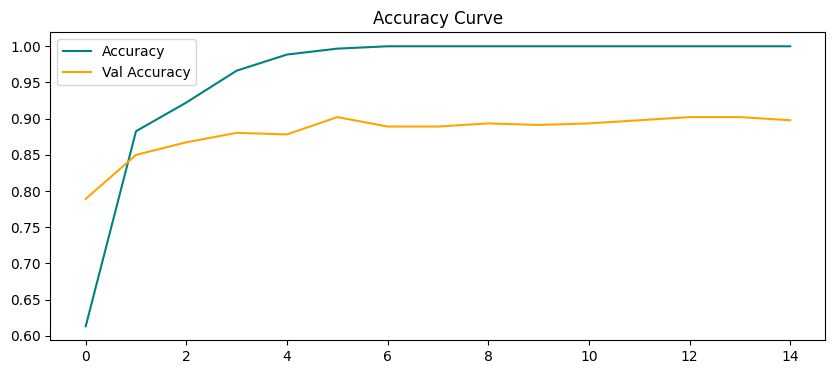

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [55]:
train_dir = r'C:\Users\bt984\Desktop\Img_classification_DL\fruit-classification10-class\MY_data\train'
test_dir = r'C:\Users\bt984\Desktop\Img_classification_DL\fruit-classification10-class\MY_data\test'

train_data, val_data, test_data, class_names = load_datasets(train_dir, test_dir)
train_data, val_data, test_data = preprocess_datasets(train_data, val_data, test_data)

model = build_model()
model.summary()

history = train_model(model, train_data, val_data, epochs=15)
plot_metrics(history)

evaluate_on_test(model, test_data)

In [56]:
class_names

['Apple',
 'Banana',
 'avocado',
 'cherry',
 'kiwi',
 'mango',
 'orange',
 'pinenapple',
 'strawberries',
 'watermelon']

# Predictions on unseen data 

In [57]:
import cv2
import numpy as np

IMAGE_SIZE = (128, 128)

def predict_image(model, img_path, class_names):
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert BGR → RGB

    resized_image = tf.image.resize(img, IMAGE_SIZE)
    scaled_image = resized_image / 255.0

    # Add batch dimension
    input_tensor = np.expand_dims(scaled_image, axis=0)

    yhat = model.predict(input_tensor)
    label_index = int(np.argmax(yhat))
    confidence = np.max(yhat)


    return class_names[label_index], confidence, img

In [58]:
fruit, conf, img = predict_image(
    model,
    r"C:\Users\bt984\Desktop\Img_classification_DL\fruit-classification10-class\MY_data\predict\img_41.jpeg",
    class_names
)

print(f"Predicted Fruit: {fruit} (Confidence: {conf:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted Fruit: avocado (Confidence: 1.00)


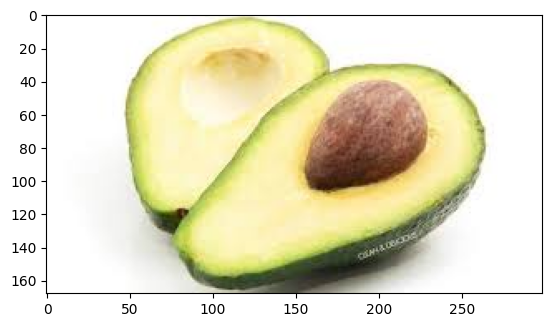

In [59]:
plt.imshow(img)
plt.show()